In [1]:
import os
import psycopg2
import pandas as pd
import numpy as np
from datetime import date
from datetime import datetime
import matplotlib
matplotlib.use('svg') 
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = 9, 6

In [3]:
# najskor treba vytvorit spojenie s databazou
hostname = 'sql.ekosystem.slovensko.digital'
port = '5432'
database = 'datahub'
username = os.environ['PG_USERNAME']
password = os.environ['PG_PASSWORD']
conn = psycopg2.connect(host=hostname, user=username, password=password, dbname=database, port=port)

## Skusme sa pozriet na to, ako sa menil pocet podpsainych zmluv zverejnenych v CRZ v case 

In [4]:
# pomocou funkcie read_sql v kniznici pandas sa da vysledok vyhodnocovania SQL prikazu spracovavat ako DataFrame
# celkovy pocet zmluv v CRZ
pd.read_sql("SELECT count(*) FROM crz.contracts", conn)

,count
0,1200414


In [5]:
# Mozeme si napriklad vytiahnut pocty podpisanych zmluv z CRZ zoskupene podla dni
signed_on_counts = pd.read_sql("SELECT count(*) AS signed_per_day, signed_on FROM crz.contracts GROUP BY signed_on ORDER BY signed_on", conn)
signed_on_counts.head()

,signed_per_day,signed_on
0,1,0002-06-03
1,1,0002-06-25
2,1,0002-10-28
3,1,0012-02-03
4,1,0012-04-24


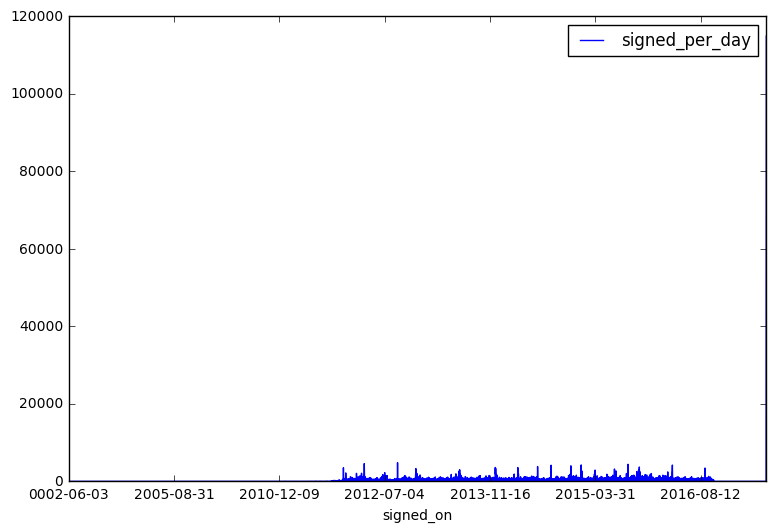

In [6]:
# A tieto vysledky velmi jednoducho vizualizovat
signed_on_counts.plot(y='signed_per_day', x='signed_on')

## Skusme sa pozriet na to, kolko zmluv nema uvedeny datum podpisu

In [7]:
# pocet zmluv bez casu podpisu
signed_on_counts[pd.isnull(signed_on_counts.signed_on)]

,signed_per_day,signed_on
3312,114914,None


## Kedze su tu nejake zvlastne rozmedzia casov, tak si skusme vybrat len tie, ktore sa zdaju aspon trochu rozumne

In [8]:
# zoznamy s podpisom medzi 1.1.2012 (CRZ bol spusteny) a dneskom
sample = signed_on_counts[(signed_on_counts.signed_on > date(2011, 1, 1)) & (signed_on_counts.signed_on < date.today())]
sample = sample.set_index('signed_on') # kedze tu uz nemame ziadne chybajuce hodnoty, tak mozeme pozuit datum ako index
sample.index = pd.to_datetime(sample.index) # transformujeme si datovy typ indexu aby sme vedeli neskor robit resampling

In [9]:
# celkovy pocet podpisanych zmluv
sample.signed_per_day.sum()

1083487

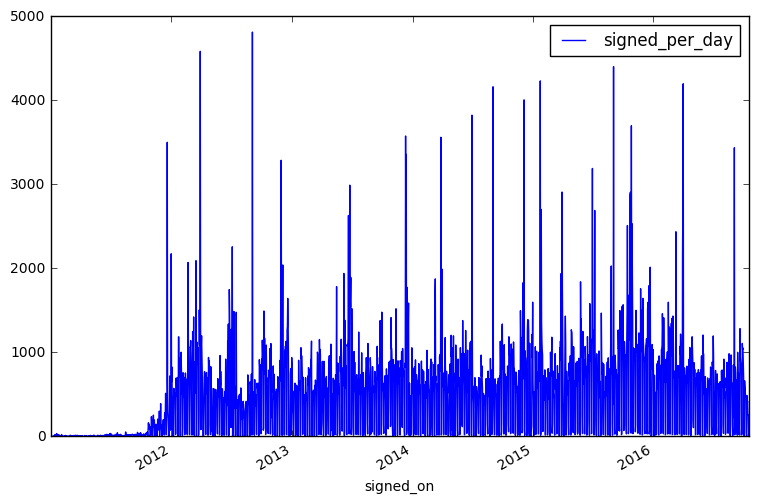

In [10]:
sample.plot()

## Kolko bolo podpisov po tyzdnoch?

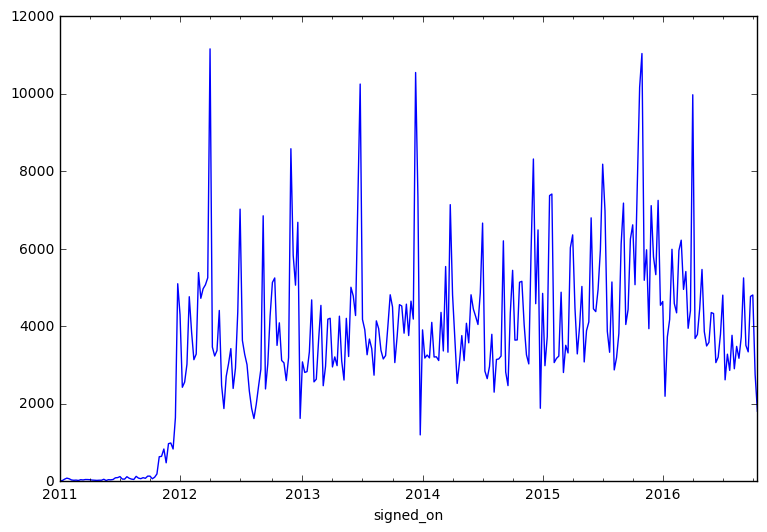

In [11]:
# kedze pouzivame casove peciatky ako index, tak vieme velmi jednoducho spravit resampling napriklad na tyzdne
sample.signed_per_day.resample('W').sum().plot()

## Kolko bolo podpisov po mesiacoch?

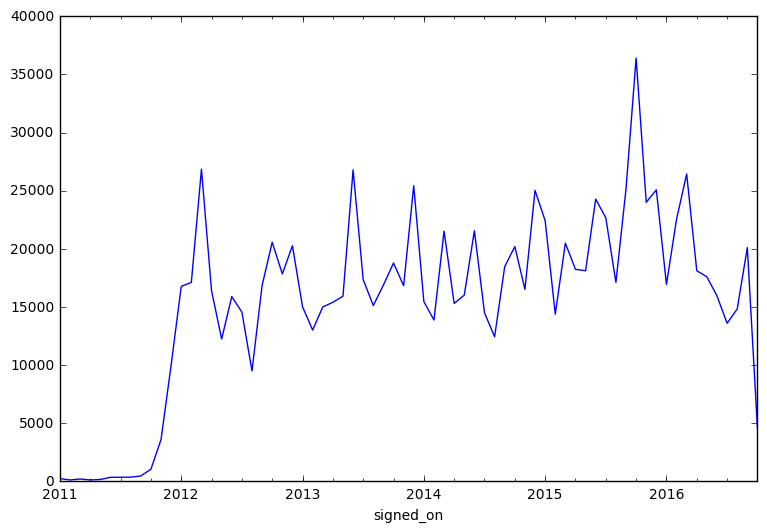

In [12]:
# rovnako vieme spravit resampling aj po mesiacoch
sample.signed_per_day.resample('M').sum().plot()

## Menil sa nejak pocet podpisanych zmluv podla toho kedy boli rozne volby?

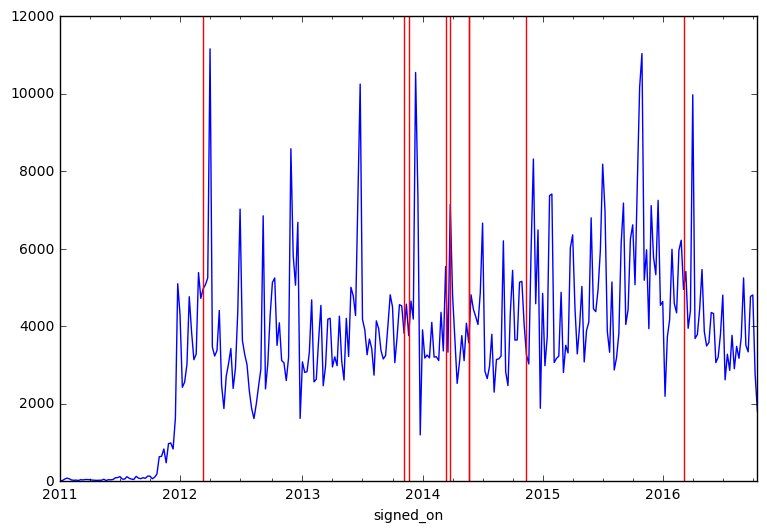

In [13]:
# Skusime si v obrazku zobrazit datumy, kedy sa konali rozne volby. Opakuje sa nejake spravanie okolo tychto dni?
sample.signed_per_day.resample('W').sum().plot()
volby = [
    datetime(2012, 3, 10), # parlamentne volby
    datetime(2013, 11, 9), # prve kolo krajskych volieb 
    datetime(2013, 11, 23), # druhe kolo krajskych volieb 
    datetime(2014, 3, 15), # prve kolo prezidentksych volieb
    datetime(2014, 3, 29), # druhe kolo prezidentksych volieb
    datetime(2014, 5, 24), # volby do Europskeho parlamentu
    datetime(2014, 5, 25), # volby do Europskeho parlamentu
    datetime(2014, 11, 15), # komunalne volby
    datetime(2016, 3, 5), # parlamentne volby
]
for datum in volby:
    plt.axvline(datum, color='r')